In [176]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

exp_inc_dosage = {0: 0.01, 1:0.026, 2:0.068, 3: 0.176, 4: 0.457, 5: 1.188, 6:3.089, 21: 5}
exp_dec_dosage = {0: 3.089, 1: 1.188, 2: 0.457, 3:0.176, 4:0.068, 5:0.026, 6:0.01, 21:5}
constant_dosage = {0: 0.714, 1: 0.714, 2: 0.714, 3: 0.714, 4: 0.714, 5: 0.714, 6: 0.714, 21: 5}
bolus21_dosage = {0: 5, 21: 5}
bolus28_dosage = {0: 5, 28: 5}
exp_inc_2wk_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 5}
bolus_prime_exp_inc_boost_dosage = {0: 5, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}
exp_inc_prime_and_boost_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}

def convert_to_tensor(dosage):
    arr = []
    for i in range(0, 41):
        arr.append(float(dosage.get(i, 0)))
    return torch.tensor(arr)

dosage_dict = {"Exp-inc": convert_to_tensor(exp_inc_dosage), "Exp-dec":convert_to_tensor(exp_dec_dosage), 
            "Constant": convert_to_tensor(constant_dosage), "Bolus": convert_to_tensor(bolus21_dosage), 
            "Boost d28": convert_to_tensor(bolus28_dosage), "Exp Increase 2wk": convert_to_tensor(exp_inc_2wk_dosage), 
            "Exp Boost": convert_to_tensor(bolus_prime_exp_inc_boost_dosage), "Exp Prime/Boost": convert_to_tensor(exp_inc_prime_and_boost_dosage)}

class Data(torch.utils.data.Dataset):
    def __init__(self, dosages, results):
        self.dosages = dosages
        self.results = results
    def __len__(self):
        return len(self.results)
    def __getitem__(self, index):
        dosage = self.dosages[index]
        result = self.results[index]
        return dosage, result

data = pd.read_csv("2024-10-27 Tam 2016 Data.csv")
data = data.replace('-', np.nan)
data = data.replace("Exp Increase 1wk", "Exp-inc")
data["Binding"] = data["Binding"].astype("float32")
data["Time"] = data["Time"].transform(lambda x: int(x[3:]))
data = data.drop(data[data["Time"]>56].index)
data = data.reset_index(drop=True)
data["Subject"] = data["Subject"].transform(lambda x: int(x[6:]))

for i in range(len(data)):
    if math.isnan(data.iloc[i, data.columns.get_loc("Binding")]):
        time = int(data.iloc[i, data.columns.get_loc("Time")])
        dosing = str(data.iloc[i, data.columns.get_loc("Vaccine Scheme")])
        mean = data[(data["Time"]==time) & (data["Vaccine Scheme"]==dosing)]["Binding"].mean()
        data.loc[i, ["Binding"]] = mean

dosages = data.groupby("Subject")["Vaccine Scheme"].nth(0)
dosages = [dosage_dict[x] for x in dosages.to_list()]
results = data.groupby("Subject")["Binding"].apply(list)
results = [torch.tensor(x) for x in results.to_list()]

epoch 1, loss 15702.826977539062
epoch 2, loss 15640.569775390624
epoch 3, loss 15529.85560913086
epoch 4, loss 15301.31844482422
epoch 5, loss 14825.13282470703
epoch 6, loss 13916.259967041016
epoch 7, loss 12472.254919433593
epoch 8, loss 10760.224548339844
epoch 9, loss 9232.749087524415
epoch 10, loss 8007.6043701171875
epoch 11, loss 7003.948995971679
epoch 12, loss 6180.738983154297
epoch 13, loss 5538.561016845703
epoch 14, loss 5074.246002197266
epoch 15, loss 4758.5052734375
epoch 16, loss 4544.962518310547
epoch 17, loss 4385.386666870118
epoch 18, loss 4244.537872314453
epoch 19, loss 4129.203723144531
epoch 20, loss 4010.8343994140623
epoch 21, loss 3903.4210510253906
epoch 22, loss 3796.189404296875
epoch 23, loss 3696.859051513672
epoch 24, loss 3599.0243530273438
epoch 25, loss 3505.663470458984
epoch 26, loss 3416.3845916748046
epoch 27, loss 3332.7212341308596
epoch 28, loss 3255.7279357910156
epoch 29, loss 3178.2864013671874
epoch 30, loss 3113.4157379150392
epoch 3

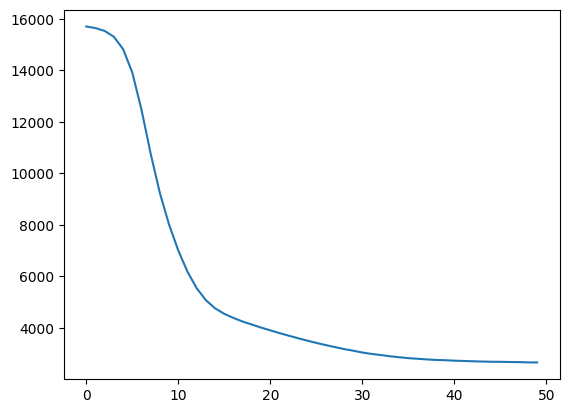

In [181]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyLinear(8))

    def forward(self, x):
        return self.net(x)

def train(model, data, epochs, lr):
    lossFunction = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prevLoss = float("inf")

    losses = []
    for i in range(1, epochs+1):
        epoch_loss = 0
        for batch in data:
            features, labels = batch
            optimizer.zero_grad()
            y_pred = model(features)
            
            loss = lossFunction(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss/len(data))
        print('epoch {}, loss {}'.format(i, epoch_loss/len(data)))

        if(epoch_loss>prevLoss):
            print("Stopped early on epoch {}".format(i))
            break
        prevLoss = epoch_loss
    
    plt.plot(range(len(losses)), losses)
    plt.show()
    

model = RegressionModel()

dataset = Data(dosages, results)
batch_size = 16
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

train(model=model, data=dataloader, epochs=50, lr=0.0005)

136.46969604492188


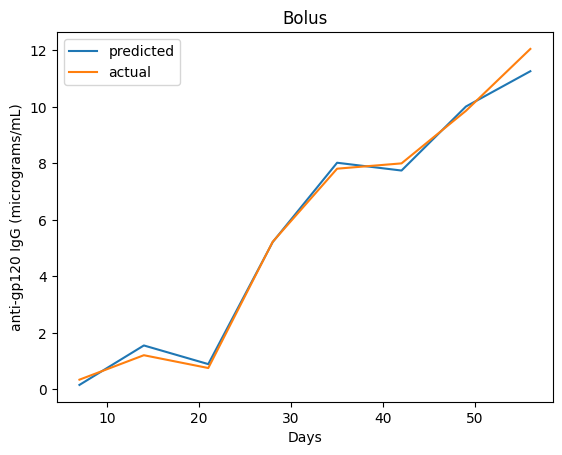

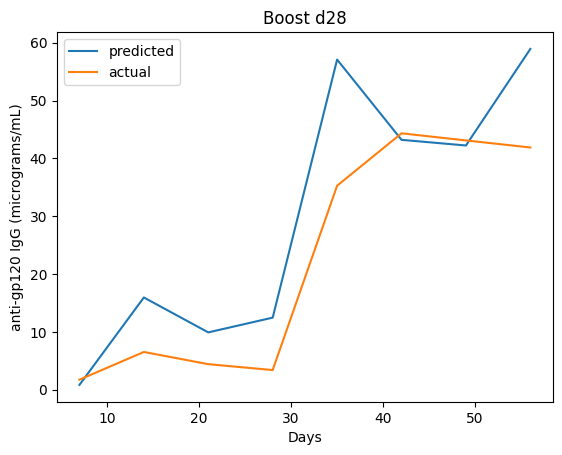

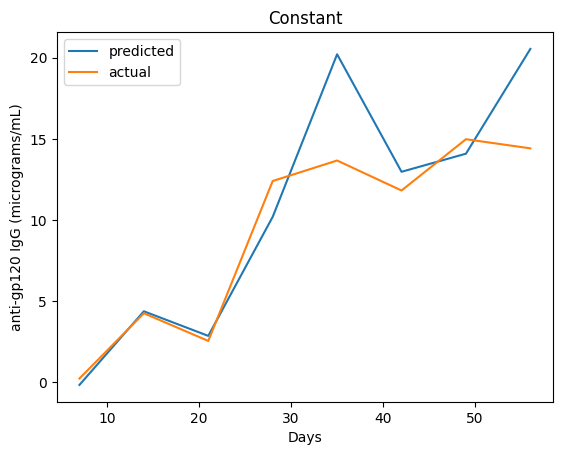

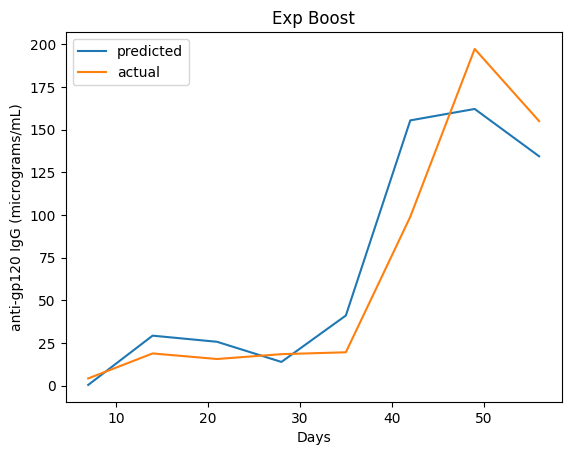

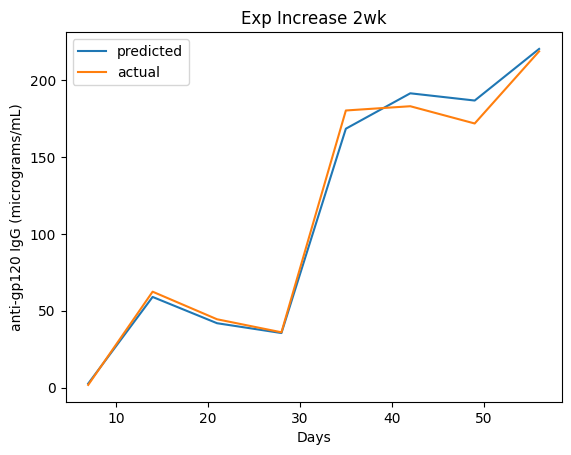

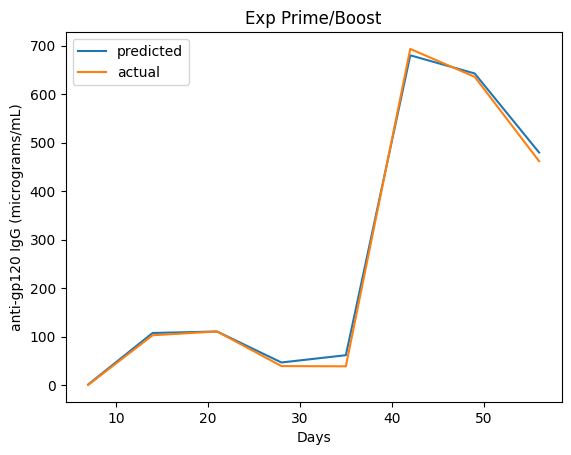

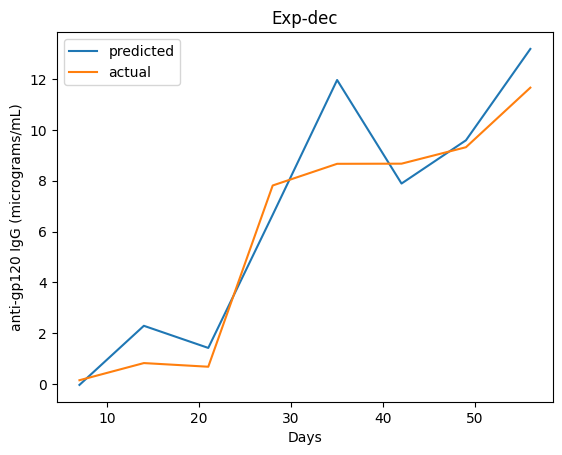

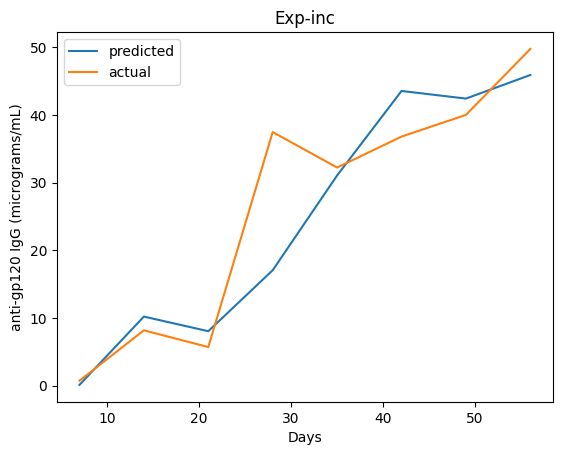

In [223]:
means = data.groupby(["Vaccine Scheme", "Time"])["Binding"].mean()
dosages = []
dosage_names = []
results = []
result = []
for index, value in means.items():
    if index[1]==7:
        dosages.append(dosage_dict[index[0]])
        dosage_names.append(index[0])
        results.append(torch.tensor(result))
        result = []
    result.append(value)
results.append(torch.tensor(result))
results = results[1:]
test_data = Data(dosages, results)

test_data = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

features, labels = next(iter(test_data))
prediction = model(features)

lossFunction = torch.nn.MSELoss(reduction="mean")
loss = lossFunction(prediction, labels)
print(loss.item())
for i, pred in enumerate(prediction):
    plt.plot(range(7, 63, 7), pred.tolist(), label="predicted")
    plt.plot(range(7, 63, 7), labels[i].tolist(), label="actual")
    ax = plt.gca()
    plt.xlabel("Days")
    plt.ylabel("anti-gp120 IgG (micrograms/mL)")
    plt.title(dosage_names[i])   
    plt.legend()
    plt.show()